In [1]:
import numpy as np
from scipy.interpolate import NearestNDInterpolator
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
from astropy import constants as const

BIGG = const.G.value
MSUN = const.M_sun.value
AU = 1.496e11
VESC = np.sqrt(2*BIGG*MSUN/(100*AU))/1000

pi = np.pi

NSTEPS = 10000
NWALKERS = 50
VSUN = np.array([10.0, 5.2, 7.2])            # from Binney and Merrifield (1998)

S1 = 26                                      # from Binney and Merrifield (1998)
S2 = 18                                      # taken for G stars
S3 = 15
PHI = 2                                      # taken from Darryl's paper

THETA = np.radians(123)                      # this comes from Jo Bovy's stellar kinematics Github
ANGP = np.radians(192.25)
DNGP = np.radians(27.4)

# Draw galactic velocities

In [2]:
def convert_to_heliocentric(vel):
    vel = vel - VSUN
    
    T1 = [[np.cos(THETA), np.sin(THETA), 0], [np.sin(THETA), -np.cos(THETA), 0], [0, 0, 1]]    
    T2 = [[-np.sin(DNGP), 0, np.cos(DNGP)], [0, 1, 0], [np.cos(DNGP), 0, np.sin(DNGP)]]        
    T3 = [[np.cos(ANGP), np.sin(ANGP), 0], [-np.sin(ANGP), np.cos(ANGP), 0], [0, 0, 1]]

    T = np.matmul(np.matmul(T1, T2), T3)
    
    return np.matmul(np.linalg.inv(T), vel)

In [3]:
def schwarzschild_distribution(v, mu1=1., mu2=1., mu3=1., s1=1., s2=1., s3=1.):
    return np.exp(-((v[0]-mu1)**2/(2*s1**2)+(v[1]-mu2)**2/(2*s2**2)+(v[2]-mu3)**2/(2*s3**2)))/((2*pi)**1.5*s1*s2*s3)

def ln_schwarzschild(v, mu1, mu2, mu3, s1, s2, s3):
    return np.log(schwarzschild_distribution(v, mu1=mu1, mu2=mu2, mu3=mu3, s1=s1, s2=s2, s3=s3))

def eta(v_inf, phi=2):
    return 1 + (42/(v_inf + phi))**2

def ln_eta(v_inf, phi):
    return np.log(eta(v_inf, phi=phi))

def ln_pdf(v, phi, mu1, mu2, mu3, s1, s2, s3):
    v_helio = convert_to_heliocentric(v)
    v_inf = np.sqrt(np.sum(v_helio**2) - VESC**2)
    
    if np.isnan(v_inf):
        return -999
    else:
        return ln_eta(v_inf, phi) + ln_schwarzschild(v, mu1, mu2, mu3, s1, s2, s3)

In [4]:
def get_f(x, logpdf, *args):
    if len(x) == 1:
        return [logpdf(x[0], *args)]
    else:
        f0 = logpdf(x[0], *args)
        return np.concatenate(([f0], get_f(x[1:], logpdf, *args)))

def mcmc_vectorized(x0, nminsteps=1, step=1., logpdf=None, args=None, nconv=1000, convergence_func=None, conv_args=None):
    x = x0
    nsteps = 0
    converged = False
    fnow = np.array(get_f(x, logpdf, *args))

    chain = [x0]
    while not converged or nsteps < nminsteps:
        xtry = x + step*np.random.uniform(-1, 1, size=x.shape)
        ftry = np.array(get_f(xtry, logpdf, *args))

        accept = np.array(ftry > fnow)
        x[accept] = xtry[accept]
        fnow[accept] = ftry[accept]
      
        u = np.random.uniform(size=x.shape[0])
        log_accept = np.array(np.log(u) < ftry - fnow)
        x[(log_accept)*(~accept)] = xtry[(log_accept)*(~accept)]
        fnow[(log_accept)*(~accept)] = ftry[(log_accept)*(~accept)]
        chain.append(np.copy(x))
        nsteps = nsteps + 1
        
        if nsteps % nconv == 0:
            if convergence_func is None:
                converged = True
            else:
                converged = convergence_func(chain, conv_args)
    
    return np.array(chain)

def gr_indicator(chain, gr_threshold=1.01):
    
    if len(np.shape(chain)) == 3:
        nsteps, nwalkers, ndim = np.shape(chain)
    elif len(np.shape(chain)) == 2:
        nsteps, nwalkers = np.shape(chain)
    else:
        nsteps = np.shape(chain)
        nwalkers = 1
    
    sj2 = np.sum((chain-np.mean(chain, axis=0))**2, axis=0)/(nsteps-1)
    sw2 = np.sum(sj2, axis=0)/nwalkers

    xjbar = np.sum(chain, axis=0)/nsteps
    xbar = np.sum(xjbar, axis=0)/nwalkers

    sv2 = (nsteps-1)*sw2/nsteps + np.sum((xjbar-xbar)**2)/(nwalkers-1)

    R_GR = sv2/sw2
    converged = np.all(R_GR < gr_threshold)
    
    return converged

In [5]:
x = np.random.normal(scale=20, size=(NWALKERS, 3))
vel = mcmc_vectorized(x, nminsteps=NSTEPS, logpdf=ln_pdf, args=(PHI, 0., 0., 0., S1, S2, S3))

<ipython-input-3-9f116d49aa31>:15: RuntimeWarning: invalid value encountered in sqrt
  v_inf = np.sqrt(np.sum(v_helio**2) - VESC**2)


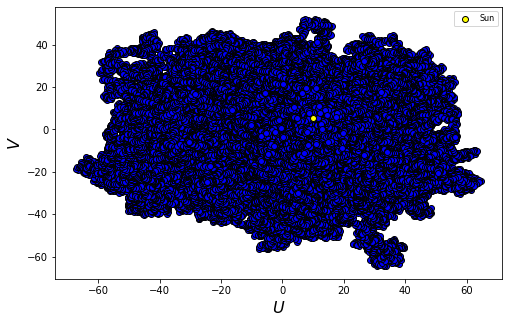

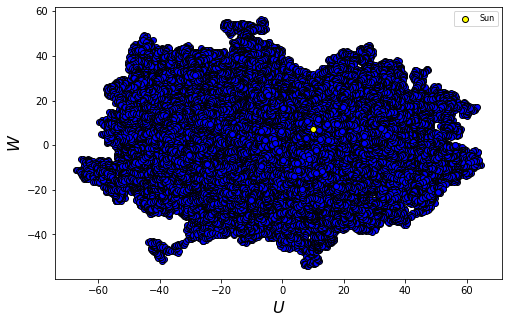

In [6]:
plt.figure(figsize=(8, 5))
plt.scatter(vel[:, :, 0], vel[:, :, 1], c='blue', edgecolor='k')
plt.scatter(VSUN[0], VSUN[1], c='yellow', edgecolor='k', label='Sun')
plt.legend(loc='upper right', fontsize=8)
plt.xlabel(r'$U$', fontsize=16)
plt.ylabel(r'$V$', fontsize=16)
plt.show()

plt.figure(figsize=(8, 5))
plt.scatter(vel[:, :, 0], vel[:, :, 2], c='blue', edgecolor='k')
plt.scatter(VSUN[0], VSUN[2], c='yellow', edgecolor='k', label='Sun')
plt.legend(loc='upper right', fontsize=8)
plt.xlabel(r'$U$', fontsize=16)
plt.ylabel(r'$W$', fontsize=16)
plt.show()

# Convert to heliocentric frame

In [7]:
NVEL = len(vel)*NWALKERS
vel = vel.reshape((NVEL, 3))
vel = vel - np.tile(VSUN, (NVEL, 1))   

In [8]:
T1 = [[np.cos(THETA), np.sin(THETA), 0], [np.sin(THETA), -np.cos(THETA), 0], [0, 0, 1]]    # this comes from Jo Bovy's
T2 = [[-np.sin(DNGP), 0, np.cos(DNGP)], [0, 1, 0], [np.cos(DNGP), 0, np.sin(DNGP)]]        # stellar kinematics github
T3 = [[np.cos(ANGP), np.sin(ANGP), 0], [-np.sin(ANGP), np.cos(ANGP), 0], [0, 0, 1]]

T = np.matmul(np.matmul(T1, T2), T3)

for i, v in enumerate(vel):
    vel[i] = np.matmul(np.linalg.inv(T), v)

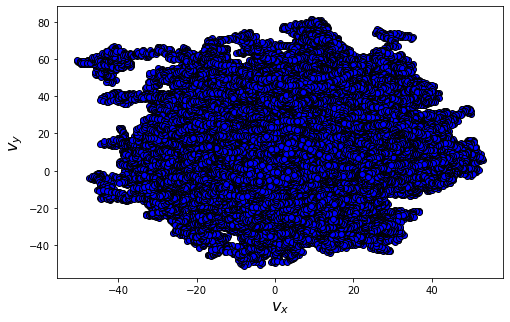

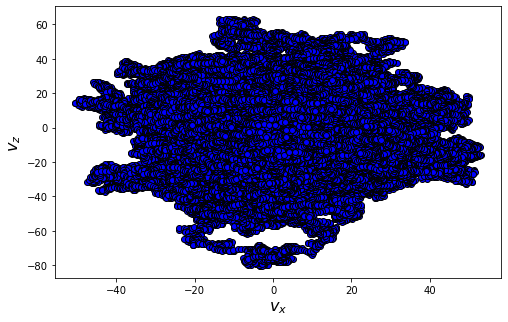

In [9]:
plt.figure(figsize=(8, 5))
plt.scatter(vel[:, 0], vel[:, 1], c='blue', edgecolor='k')
plt.xlabel(r'$v_{x}$', fontsize=16)
plt.ylabel(r'$v_{y}$', fontsize=16)
plt.show()

plt.figure(figsize=(8, 5))
plt.scatter(vel[:, 0], vel[:, 2], c='blue', edgecolor='k')
plt.xlabel(r'$v_{x}$', fontsize=16)
plt.ylabel(r'$v_{z}$', fontsize=16)
plt.show()

# Get initial positions

In [10]:
def get_ra_dec(v):
    mag = np.sqrt(np.sum(v**2))
    dec = np.arcsin(v[2]/mag)
    if v[1]/mag > 0:
        ra = np.arccos(v[0]/(mag*np.cos(dec)))
    else:
        ra = 2*pi-np.arccos(v[0]/(mag*np.cos(dec)))
    if ra > pi:
        ra = ra - 2*pi
    return np.asarray([ra, dec])

pos = np.zeros((NVEL, 2))
for i, v in enumerate(vel):
    pos[i] = get_ra_dec(-v)                             # draw vector pointing towards object rather than away from it

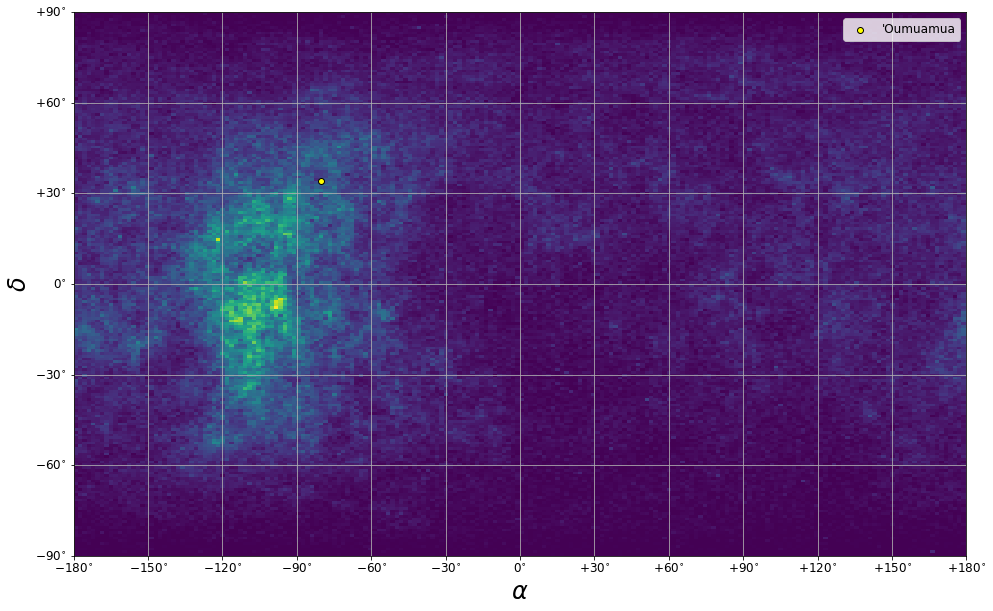

In [11]:
OUMUAMUA_COORDS = [np.radians(279.804-360), np.radians(33.997)]            # from Mamajek (2017)

plt.figure(figsize=(16, 10))
plt.hist2d(pos[:, 0], pos[:, 1], bins=200)

plt.xlabel(r'$\alpha$', fontsize=24)
plt.xticks([-pi, -5*pi/6, -2*pi/3, -pi/2, -pi/3, -pi/6, 0, pi/6, pi/3, pi/2, 2*pi/3, 5*pi/6, pi], [r'$-180^{\circ}$', \
        r'$-150^{\circ}$', r'$-120^{\circ}$', r'$-90^{\circ}$', r'$-60^{\circ}$', r'$-30^{\circ}$', r'$0^{\circ}$', \
        r'$+30^{\circ}$', r'$+60^{\circ}$', r'$+90^{\circ}$', r'$+120^{\circ}$', r'$+150^{\circ}$', r'$+180^{\circ}$'], \
          fontsize=12)

plt.ylabel(r'$\delta$', fontsize=24)
plt.yticks([-pi/2, -pi/3, -pi/6, 0, pi/6, pi/3, pi/2], [r'$-90^{\circ}$', r'$-60^{\circ}$', r'$-30^{\circ}$', \
        r'$0^{\circ}$', r'$+30^{\circ}$', r'$+60^{\circ}$', r'$+90^{\circ}$'], fontsize=12)
plt.grid(True)

plt.scatter(OUMUAMUA_COORDS[0], OUMUAMUA_COORDS[1], c='yellow', edgecolor='k', label="'Oumuamua")
plt.legend(loc='upper right', fontsize=12)

plt.show()